In [12]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score,classification_report,pairwise_distances_argmin_min,silhouette_score, hamming_loss, f1_score, precision_score, recall_score, jaccard_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from preprocess_data import preprocess_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_distances,pairwise_distances
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.linear_model import SGDClassifier
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
data = preprocess_data()
data['num_genres'] = data['genre'].apply(len)
data = data[data['num_genres'] == 1]
descriptions = data['description_processed'].tolist()
genres = data['genre'].tolist()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(genres)
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
X = model.encode(descriptions, show_progress_bar=True)

/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Batches: 100%|██████████| 762/762 [01:09<00:00, 11.04it/s]


In [15]:
initial_train_size = 250
iterations = 20
uncertainty_threshold = 0.2
budget_per_iteration = 500
methods = ['random', 'entropy', 'margin', 'cluster']    

In [5]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_full_normalized = normalize(X_train_full, axis=1, norm='l2')
X_test_normalized = normalize(X_test, axis=1, norm='l2')
np.random.seed(42)
initial_indices = np.random.choice(len(X_train_full_normalized), initial_train_size, replace=False)

### Code for Non-random Centroid Initialization

In [45]:
centroid_sentences = genre_descriptions = [
    "intense physical confrontations fast paced sequences featuring combat explosions high stakes conflict",
    "epic journeys heroic quests dangerous adventures often in fantastical settings exploration unknown",
    "animated storytelling visual artistry non-human characters imaginative worlds surreal narratives",
    "detailed accounts real-life individuals focusing on personal achievements significant historical moments",
    "comedic scenarios witty dialogues humor-based interactions aimed at evoking laughter entertainment",
    "depictions organized crime criminal behavior investigations heists underworld activities law enforcement",
    "deep emotional narratives character evolution often dealing with life-altering events personal challenges",
    "family-friendly themes focusing on relationships nurturing positive lessons designed for younger audiences",
    "magical realms supernatural beings mystical adventures crossing boundaries between reality imagination",
    "historical recreations focusing on pivotal events important eras real historical figures shaping world events",
    "crafted to evoke fear suspense often involving supernatural forces psychological terror or extreme violence",
    "stories centered around music performers musicians using songs as narrative devices to advance plot",
    "musical storytelling with elaborate performances dance sequences centered around theatrical music numbers",
    "intricate narratives involving crime detective work solving mysteries uncovering secrets unexpected twists",
    "narratives centered on romantic relationships emotional intimacy personal growth often amidst challenges",
    "explorations advanced technology futuristic societies space travel speculative science uncharted concepts",
    "competitive sports athletic achievement depicting struggles victories focus on physical and mental endurance",
    "psychological tension high stakes thrillers featuring danger suspense shocking revelations complex plots",
    "military combat war strategies depictions battles focusing on heroism sacrifice wartime experiences",
    "western frontier themes cowboys outlaws gunfights rugged landscapes lawlessness moral dilemmas"
]

centroid_vecs = model.encode(centroid_sentences, show_progress_bar=True)
centroid_vecs = normalize(centroid_vecs, axis=1, norm='l2')
centroid_vecs = np.array(centroid_vecs)

Batches: 100%|██████████| 1/1 [00:00<00:00, 15.49it/s]


In [56]:
def sample_non_random_init(method, X_train, X_pool, remaining_indices, budget):
    if method == 'random':
        return np.random.choice(remaining_indices, budget, replace=False)
    
    elif method == 'cluster':
        num_clusters = 20
        #clustering = faiss.Clustering(X_train.shape[1], num_clusters)
        #clustering.verbose = False
        #clustering.niter = 50
        remaining_data = np.array([X_pool[i] for i in remaining_indices]).astype('float32')
        #index_flat = faiss.IndexFlatIP(X_train.shape[1])
        #index_flat.add(centroid_vecs.astype('float32'))
        #clustering.train(remaining_data, index_flat)
        #D, cluster_assignments = index_flat.search(remaining_data, 1)
        #cluster_assignments = cluster_assignments.flatten()
        #centroids = faiss.vector_to_array(clustering.centroids).reshape(num_clusters, X_train.shape[1])
        kmeans = KMeans(n_clusters=num_clusters, init=centroid_vecs, n_init=1, max_iter=100)
        kmeans.fit(remaining_data)
        cluster_assignments = kmeans.labels_
        final_centroids = kmeans.cluster_centers_

        selected_indices = []
        for cluster in range(num_clusters):
            cluster_indices = [i for i, label in zip(remaining_indices, cluster_assignments) if label == cluster]
            if cluster_indices:
                num_to_select_from_cluster = min((int((500/num_clusters)/2)), int(len(cluster_indices)/2))
                cluster_data = X_pool[np.array(cluster_indices)]
                cluster_center = final_centroids[cluster].reshape(1, -1)
                distances = np.linalg.norm(cluster_data - cluster_center, axis=1)
                #distances, _ = index_flat.search(cluster_center, len(cluster_indices))
                closest_samples = set([cluster_indices[i] for i in distances[0].argsort()[:num_to_select_from_cluster]])

                pairwise_distances_matrix = pairwise_distances(cluster_data)
                diversity_scores = pairwise_distances_matrix.mean(axis=1)
                most_diverse_indices = set([cluster_indices[i] for i in np.argsort(-diversity_scores)[:num_to_select_from_cluster]])
                selected_indices.extend(list(closest_samples.union(most_diverse_indices)))

        return selected_indices

### Continue Here

In [6]:
def sample(method, X_train, X_pool, remaining_indices, budget, clf):
    if method == 'random':
        return np.random.choice(remaining_indices, budget, replace=False)
    
    elif method == 'margin':
        probs = clf.predict_proba(X_pool)
        sorted_probs = np.sort(probs, axis=1) 
        margins = sorted_probs[:, -1] - sorted_probs[:, -2]
        return np.argsort(margins)[:budget]  
    
    elif method == 'entropy':
        probs = clf.predict_proba(X_pool)
        entropies = -np.sum(probs * np.log(probs), axis=1)
        return np.argsort(entropies)[:budget]
    
    elif method == 'cluster':
        num_clusters = 20
        clustering = faiss.Clustering(X_train.shape[1], num_clusters)
        clustering.verbose = False
        clustering.niter = 50
        remaining_data = np.array([X_pool[i] for i in remaining_indices]).astype('float32')
        index_flat = faiss.IndexFlatIP(X_train.shape[1])
        clustering.train(remaining_data, index_flat)
        D, cluster_assignments = index_flat.search(remaining_data, 1)
        cluster_assignments = cluster_assignments.flatten()
        centroids = faiss.vector_to_array(clustering.centroids).reshape(num_clusters, X_train.shape[1])

        selected_indices = []
        for cluster in range(num_clusters):
            cluster_indices = [i for i, label in zip(remaining_indices, cluster_assignments) if label == cluster]
            if cluster_indices:
                num_to_select_from_cluster = min((int((500/num_clusters)/2)), int(len(cluster_indices)/3))
                cluster_data = X_pool[np.array(cluster_indices)]
                cluster_center = centroids[cluster].reshape(1, -1)
                distances, _ = index_flat.search(cluster_center, len(cluster_indices))
                closest_samples = [cluster_indices[i] for i in distances[0].argsort()[:num_to_select_from_cluster]]
                selected_indices.extend(closest_samples)

                pairwise_distances_matrix = pairwise_distances(cluster_data)
                diversity_scores = pairwise_distances_matrix.mean(axis=1)
                most_diverse_indices = set([cluster_indices[i] for i in np.argsort(-diversity_scores)[:num_to_select_from_cluster]])
                selected_indices.extend(most_diverse_indices)

                probs = clf.predict_proba(cluster_data)
                uncertainty = 1 - np.max(probs, axis=1)
                sorted_indices = np.argsort(-uncertainty)
                selected_cluster_indices = [cluster_indices[i] for i in sorted_indices[:num_to_select_from_cluster]]
                selected_indices.extend(selected_cluster_indices)

        return list(set(selected_indices))

In [16]:
acc_dict, f1_dict, prec_dict, rec_dict = {}, {}, {}, {}
for method in methods:
    print(f'Running active learning with {method} sampling')
    clf = SGDClassifier(loss='log_loss', random_state=42)
    accuracies, f1_scores, precs, recalls = [], [], [], []
    X_train = X_train_full_normalized[initial_indices]
    y_train = np.array(y_train_full)[initial_indices]
    remaining_indices = list(set(range(len(X_train_full_normalized))) - set(initial_indices))
    for iteration in range(iterations):
        clf.partial_fit(X_train, y_train, classes=np.unique(y_train_full))
        y_pred = clf.predict(X_test_normalized)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        prec = precision_score(y_test, y_pred, average='macro')
        rec = recall_score(y_test, y_pred, average='macro')
        accuracies.append(acc)   
        f1_scores.append(f1)
        precs.append(prec)
        recalls.append(rec)
        print(f'Iteration {iteration + 1}/{iterations} - Accuracy: {acc}, F1: {f1}, Precision: {prec}, Recall: {rec}')
        selected_indices = sample(method, X_train, X_train_full_normalized, remaining_indices, budget_per_iteration, clf)
        X_train = np.vstack((X_train, X_train_full_normalized[selected_indices]))
        y_train = np.concatenate((y_train, np.array(y_train_full)[selected_indices]))
        remaining_indices = list(set(remaining_indices) - set(selected_indices))
        
    print(classification_report(y_test, y_pred))
    acc_dict[method] = accuracies
    f1_dict[method] = f1_scores
    prec_dict[method] = precs
    rec_dict[method] = recalls
        

Running active learning with random sampling
Iteration 1/20 - Accuracy: 0.3736399096694724, F1: 0.07582650274658864, Precision: 0.17546735957815934, Recall: 0.08729480801467845
Iteration 2/20 - Accuracy: 0.4426195853007596, F1: 0.17327208254313722, Precision: 0.1758746436813642, Recall: 0.22071404572954906


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined an

Iteration 3/20 - Accuracy: 0.5838636830219668, F1: 0.1315948884616749, Precision: 0.23525912800136548, Recall: 0.12720356896730176
Iteration 4/20 - Accuracy: 0.5809895298706631, F1: 0.19801054603527762, Precision: 0.26054997328671875, Recall: 0.20049601091695016


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 5/20 - Accuracy: 0.6351878464381031, F1: 0.19737480488460918, Precision: 0.26269175251354326, Recall: 0.18561644954950113


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 6/20 - Accuracy: 0.5933073290905359, F1: 0.1716240591713688, Precision: 0.2614489042060875, Recall: 0.16543928686960918


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 7/20 - Accuracy: 0.5933073290905359, F1: 0.1531780253138964, Precision: 0.30951636384703457, Recall: 0.13333519290771953


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 8/20 - Accuracy: 0.6335454732087867, F1: 0.20164434181569796, Precision: 0.3004973798363251, Recall: 0.18773131434076795


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 9/20 - Accuracy: 0.6368302196674194, F1: 0.2005849789516915, Precision: 0.3457905074113451, Recall: 0.18326201004382406


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 10/20 - Accuracy: 0.632929583247793, F1: 0.17975135900359046, Precision: 0.25785380420755877, Recall: 0.1627018781508055


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 11/20 - Accuracy: 0.6292342434818312, F1: 0.18982630410095394, Precision: 0.3206646745290828, Recall: 0.17038110718817062


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 12/20 - Accuracy: 0.6452473824676658, F1: 0.19615464094494234, Precision: 0.3235887650831731, Recall: 0.18085707036542673


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 13/20 - Accuracy: 0.6440156025456785, F1: 0.22804044618397837, Precision: 0.3559888831610377, Recall: 0.20506301987028924


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 14/20 - Accuracy: 0.6433997125846849, F1: 0.20907598064228433, Precision: 0.3874491149707793, Recall: 0.18359914324997464


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 15/20 - Accuracy: 0.6466844590433176, F1: 0.2127132918641952, Precision: 0.34002618455607425, Recall: 0.19366306468865518


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 16/20 - Accuracy: 0.6464791623896531, F1: 0.21739601581683504, Precision: 0.36761953489912647, Recall: 0.19272429179522435


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 17/20 - Accuracy: 0.6466844590433176, F1: 0.2226570851723686, Precision: 0.3534024327085261, Recall: 0.20524389682665642


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 18/20 - Accuracy: 0.6386778895504003, F1: 0.18800251820334912, Precision: 0.31399193031168526, Recall: 0.17046578805548593


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 19/20 - Accuracy: 0.644220899199343, F1: 0.21567124720194847, Precision: 0.3623336041722866, Recall: 0.19553986271569873


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined an

Iteration 20/20 - Accuracy: 0.6468897556969821, F1: 0.21487286803882485, Precision: 0.3644155679274924, Recall: 0.19059071487661539
              precision    recall  f1-score   support

           0       0.61      0.31      0.41       134
           1       0.60      0.06      0.12        47
           2       0.00      0.00      0.00        19
           3       0.00      0.00      0.00        10
           4       0.61      0.63      0.62      1371
           5       0.00      0.00      0.00        35
           6       0.66      0.82      0.73      2233
           7       0.60      0.06      0.10        53
           8       0.00      0.00      0.00        15
           9       0.00      0.00      0.00         5
          10       0.69      0.66      0.67       406
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00        16
          13       0.00      0.00      0.00        23
          14       0.50      0.01      0.02        80
   

/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 2/20 - Accuracy: 0.4703346335454732, F1: 0.17016111305747703, Precision: 0.20159771033645066, Recall: 0.1703080395535712
Iteration 3/20 - Accuracy: 0.5076986245124204, F1: 0.14959250892622347, Precision: 0.21286764099373165, Recall: 0.17229677464784982


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 4/20 - Accuracy: 0.5721617737630876, F1: 0.1359553129751156, Precision: 0.23256770622487916, Recall: 0.12868444132070456


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 5/20 - Accuracy: 0.5811948265243276, F1: 0.12229051535765405, Precision: 0.16058267277003163, Recall: 0.11409255750598435


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 6/20 - Accuracy: 0.5795524532950113, F1: 0.12664896029328027, Precision: 0.14591110200779048, Recall: 0.121719338703283


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 7/20 - Accuracy: 0.5460890987476904, F1: 0.12497973403761362, Precision: 0.14471417065956726, Recall: 0.12247592653135031


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 8/20 - Accuracy: 0.5894066926709095, F1: 0.1159744150923038, Precision: 0.1446845303461995, Recall: 0.1092857717868529


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 9/20 - Accuracy: 0.5842742763292958, F1: 0.11865295363211818, Precision: 0.13822793643260362, Recall: 0.11878666837181302


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 10/20 - Accuracy: 0.5844795729829604, F1: 0.11196285915612528, Precision: 0.14319584182902106, Recall: 0.1083793369067163


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 11/20 - Accuracy: 0.5750359269143913, F1: 0.10662215811785762, Precision: 0.14407371324081777, Recall: 0.1041506614980392


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 12/20 - Accuracy: 0.5793471566413467, F1: 0.09771300190865935, Precision: 0.14719347631030244, Recall: 0.09973039022502352


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 13/20 - Accuracy: 0.5551221515089304, F1: 0.088431008195651, Precision: 0.16815512601608354, Recall: 0.09134427757834841


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 14/20 - Accuracy: 0.5686717306507904, F1: 0.09232329686826957, Precision: 0.15223465765647365, Recall: 0.09354120661162345


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 15/20 - Accuracy: 0.5799630466023403, F1: 0.09737790340477828, Precision: 0.14628895838623363, Recall: 0.09801802315763894


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 16/20 - Accuracy: 0.5777047834120304, F1: 0.09006317768005093, Precision: 0.16925669643810573, Recall: 0.09095828313063206


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 17/20 - Accuracy: 0.5807842332169986, F1: 0.09275723601912804, Precision: 0.1552774378171029, Recall: 0.09236351709287909


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 18/20 - Accuracy: 0.5746253336070622, F1: 0.08919562569314232, Precision: 0.15591707512551084, Recall: 0.0905599969285998


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 19/20 - Accuracy: 0.5774994867583658, F1: 0.08801204743854016, Precision: 0.15334467709628224, Recall: 0.0895258777767679


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined an

Iteration 20/20 - Accuracy: 0.5752412235680558, F1: 0.08748296016086013, Precision: 0.16881264299390192, Recall: 0.089273733608152
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       134
           1       0.00      0.00      0.00        47
           2       0.00      0.00      0.00        19
           3       0.00      0.00      0.00        10
           4       0.51      0.60      0.55      1371
           5       0.00      0.00      0.00        35
           6       0.60      0.82      0.69      2233
           7       0.00      0.00      0.00        53
           8       0.00      0.00      0.00        15
           9       0.00      0.00      0.00         5
          10       0.77      0.35      0.48       406
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00        16
          13       0.00      0.00      0.00        23
          14       0.00      0.00      0.00        80
    

/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 2/20 - Accuracy: 0.5495791418599877, F1: 0.1674209038673249, Precision: 0.21135164807918083, Recall: 0.16934988158979689
Iteration 3/20 - Accuracy: 0.5787312666803531, F1: 0.164745370785284, Precision: 0.2002367509249384, Recall: 0.17768687570379166


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 4/20 - Accuracy: 0.5629234243481831, F1: 0.17180081800077987, Precision: 0.23369412689993935, Recall: 0.18727179674562583


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 5/20 - Accuracy: 0.6179429275302812, F1: 0.19019613415076517, Precision: 0.232131812480596, Recall: 0.17374605310236163


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 6/20 - Accuracy: 0.6214329706425785, F1: 0.21337332574676066, Precision: 0.3649738019830791, Recall: 0.19566591980811016


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 7/20 - Accuracy: 0.6160952576473003, F1: 0.19837817199533717, Precision: 0.2516055793904063, Recall: 0.18096594237676314


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 8/20 - Accuracy: 0.6273865735988503, F1: 0.21079105772369125, Precision: 0.2824591866379067, Recall: 0.19404726579504847


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 9/20 - Accuracy: 0.6037774584274276, F1: 0.176631025071941, Precision: 0.29350606570531995, Recall: 0.1572532297104882


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 10/20 - Accuracy: 0.6236912338328885, F1: 0.2147984453967402, Precision: 0.3168124726380017, Recall: 0.19654948353685736


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 11/20 - Accuracy: 0.6314925066721413, F1: 0.21303749626675214, Precision: 0.32633028406487374, Recall: 0.1896753860260225


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 12/20 - Accuracy: 0.623896530486553, F1: 0.19308473783312113, Precision: 0.2749376563773323, Recall: 0.17407216578995793


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 13/20 - Accuracy: 0.6337507698624513, F1: 0.2035024814173938, Precision: 0.2612865912691519, Recall: 0.18812580611636864


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 14/20 - Accuracy: 0.6310819133648121, F1: 0.1910065081719462, Precision: 0.2833357013841101, Recall: 0.17034949384533998


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 15/20 - Accuracy: 0.6364196263600903, F1: 0.20325168294206403, Precision: 0.2778755488308692, Recall: 0.18493827141908986


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 16/20 - Accuracy: 0.6333401765551222, F1: 0.1981407423517546, Precision: 0.28545616485363984, Recall: 0.17754076675364697


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 17/20 - Accuracy: 0.6364196263600903, F1: 0.21542482396902107, Precision: 0.3005522899976466, Recall: 0.19594574855107194


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 18/20 - Accuracy: 0.6403202627797167, F1: 0.2266883210906343, Precision: 0.30123178159739894, Recall: 0.20513372176886085


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 19/20 - Accuracy: 0.6411414493943749, F1: 0.21257233183343108, Precision: 0.2809419387069608, Recall: 0.193085951748736


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined an

Iteration 20/20 - Accuracy: 0.6372408129747485, F1: 0.21132974787659936, Precision: 0.29399393934297724, Recall: 0.18927469606293112
              precision    recall  f1-score   support

           0       0.56      0.37      0.44       134
           1       0.67      0.13      0.21        47
           2       0.00      0.00      0.00        19
           3       0.00      0.00      0.00        10
           4       0.64      0.54      0.58      1371
           5       0.00      0.00      0.00        35
           6       0.64      0.86      0.73      2233
           7       0.75      0.06      0.11        53
           8       0.00      0.00      0.00        15
           9       0.00      0.00      0.00         5
          10       0.73      0.62      0.67       406
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00        16
          13       0.00      0.00      0.00        23
          14       0.00      0.00      0.00        80
  

/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 2/20 - Accuracy: 0.5103674810100596, F1: 0.1331486292742833, Precision: 0.23530060572562075, Recall: 0.13072032743986828


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 3/20 - Accuracy: 0.4879901457606241, F1: 0.20058983277499767, Precision: 0.24281559860013768, Recall: 0.2330683472888191


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 4/20 - Accuracy: 0.5877643194415931, F1: 0.17550785319760392, Precision: 0.34832411563395227, Recall: 0.1604111172074544


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 5/20 - Accuracy: 0.6105522479983576, F1: 0.18812759181531274, Precision: 0.3550790111017323, Recall: 0.17437587856170395


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 6/20 - Accuracy: 0.6247177171012113, F1: 0.2356534354749206, Precision: 0.34255289990783216, Recall: 0.21506401680433163


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 7/20 - Accuracy: 0.6316978033258058, F1: 0.20785200563401768, Precision: 0.36392990467576747, Recall: 0.18984750780178963


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 8/20 - Accuracy: 0.6386778895504003, F1: 0.21594821126335165, Precision: 0.3366237745533788, Recall: 0.19483238269632192


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 9/20 - Accuracy: 0.6343666598234449, F1: 0.21500574401585065, Precision: 0.3071298466319494, Recall: 0.18940833102527693


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 10/20 - Accuracy: 0.6255389037158694, F1: 0.17538375442340942, Precision: 0.2641270521592641, Recall: 0.1558101666344896


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 11/20 - Accuracy: 0.6444261958530076, F1: 0.21966930877485744, Precision: 0.3346242883794381, Recall: 0.1945613672304329


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 12/20 - Accuracy: 0.6388831862040649, F1: 0.22178947617537753, Precision: 0.31079199799635787, Recall: 0.1981471692601165


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 13/20 - Accuracy: 0.6440156025456785, F1: 0.2217212435152165, Precision: 0.34054072649502726, Recall: 0.19648146950753986


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 14/20 - Accuracy: 0.6477109423116403, F1: 0.23093013127126688, Precision: 0.32973238470588245, Recall: 0.20919281654982563


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 15/20 - Accuracy: 0.6487374255799631, F1: 0.22540070449775657, Precision: 0.368948469646134, Recall: 0.1995395682658459


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 16/20 - Accuracy: 0.6485321289262985, F1: 0.2232985178103381, Precision: 0.33819744795333195, Recall: 0.20228761407785262


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 17/20 - Accuracy: 0.6431944159310203, F1: 0.22081096878775913, Precision: 0.34441285055643467, Recall: 0.1947500093013659


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 18/20 - Accuracy: 0.648326832272634, F1: 0.2092074364985066, Precision: 0.3000793924658529, Recall: 0.18864971768404454


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 19/20 - Accuracy: 0.6489427222336276, F1: 0.22130654559330726, Precision: 0.3624522863400525, Recall: 0.19834218922284022


/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Iteration 20/20 - Accuracy: 0.6497639088482857, F1: 0.2042106135165202, Precision: 0.2934811353101284, Recall: 0.18650901450097207
              precision    recall  f1-score   support

           0       0.58      0.31      0.41       134
           1       0.67      0.09      0.15        47
           2       0.00      0.00      0.00        19
           3       0.00      0.00      0.00        10
           4       0.63      0.61      0.62      1371
           5       0.00      0.00      0.00        35
           6       0.66      0.84      0.74      2233
           7       0.75      0.06      0.11        53
           8       0.00      0.00      0.00        15
           9       0.00      0.00      0.00         5
          10       0.68      0.66      0.67       406
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00        16
          13       0.00      0.00      0.00        23
          14       0.00      0.00      0.00        80
    

/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/student/.cache/pypoetry/virtualenvs/dataanalysisvisualizationfiles-qa5NmZKI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined an

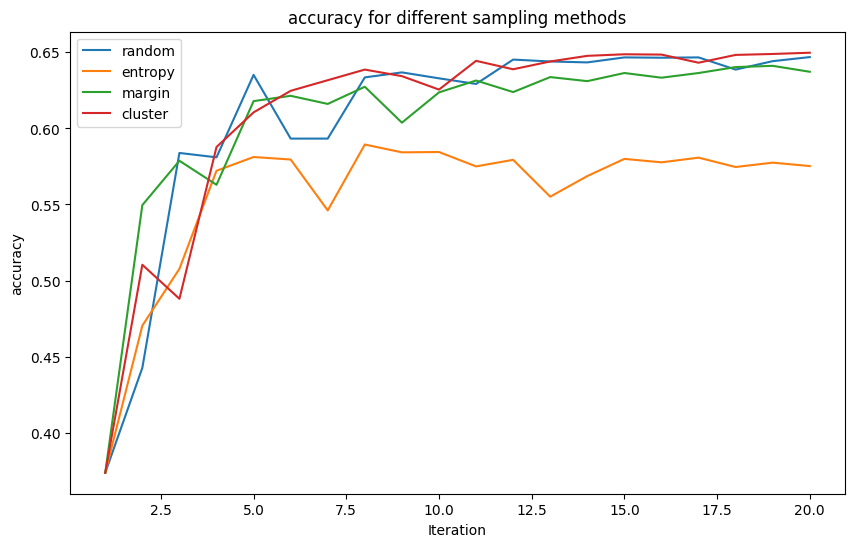

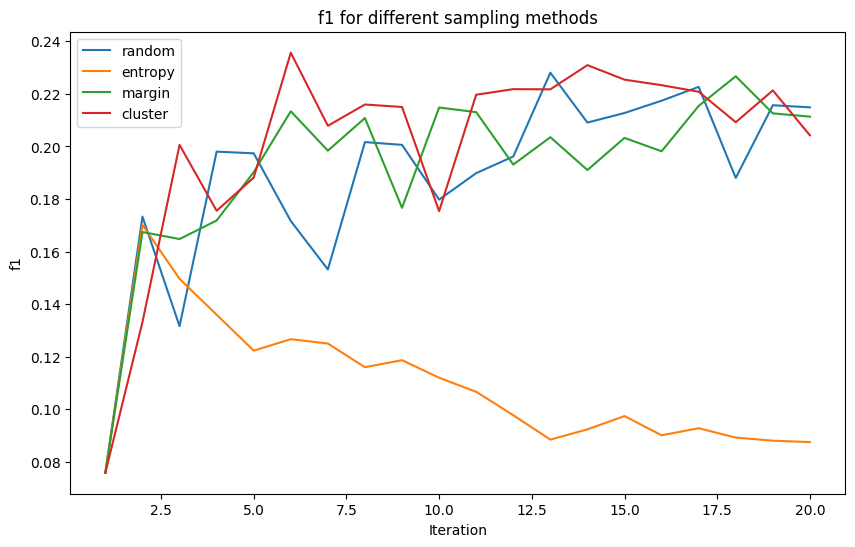

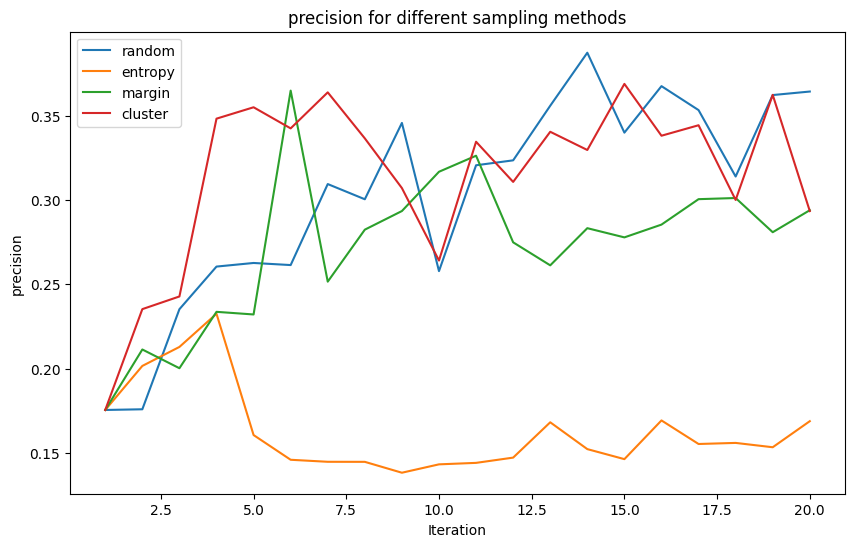

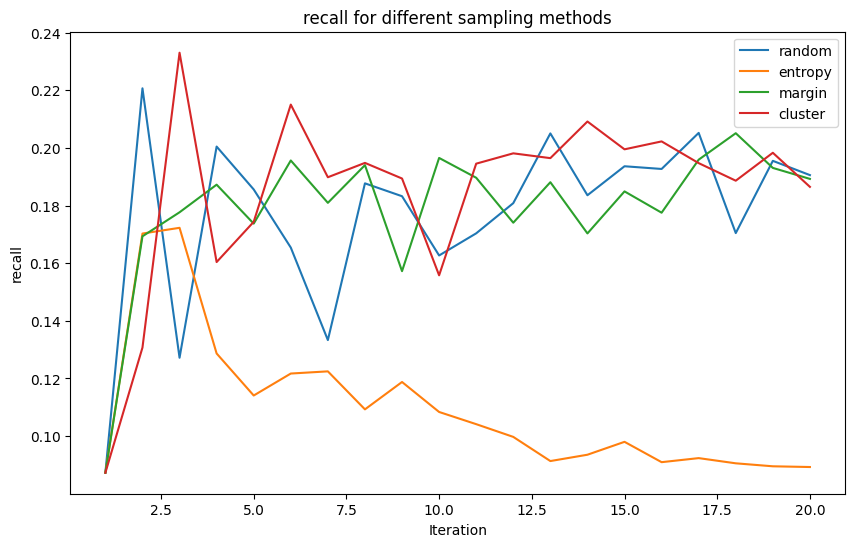

In [17]:

dics = {'accuracy': acc_dict, 'f1': f1_dict, 'precision': prec_dict, 'recall': rec_dict}
its = np.arange(1, iterations + 1)
for metric, dic in dics.items():
    plt.figure(figsize=(10, 6))
    for name, values in dic.items():
        sns.lineplot(x=its, y=values, label=name)
    plt.xlabel('Iteration')
    plt.ylabel(metric)
    plt.title(f'{metric} for different sampling methods')
    plt.legend()
    plt.savefig(f'{metric}_active_learning.png')
    plt.show()
 
